In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df=pd.read_csv("co2_mm_mlo.csv")

In [4]:
df.dtypes

year              int64
month             int64
decimal_date    float64
average         float64
interpolated    float64
dtype: object

In [5]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [6]:
df['Date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})
df.head()
# df=df[['Date','interpolated']]

,year,month,decimal_date,average,interpolated,Date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [7]:
df=df[['Date','interpolated']]
df = df.set_index('Date')
df.head()

,interpolated
Date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [8]:
# df.index.freq = 'MS'
# df.head()

In [9]:
# df_monthly = df.resample('M').mean()
df.index.freq = 'MS'

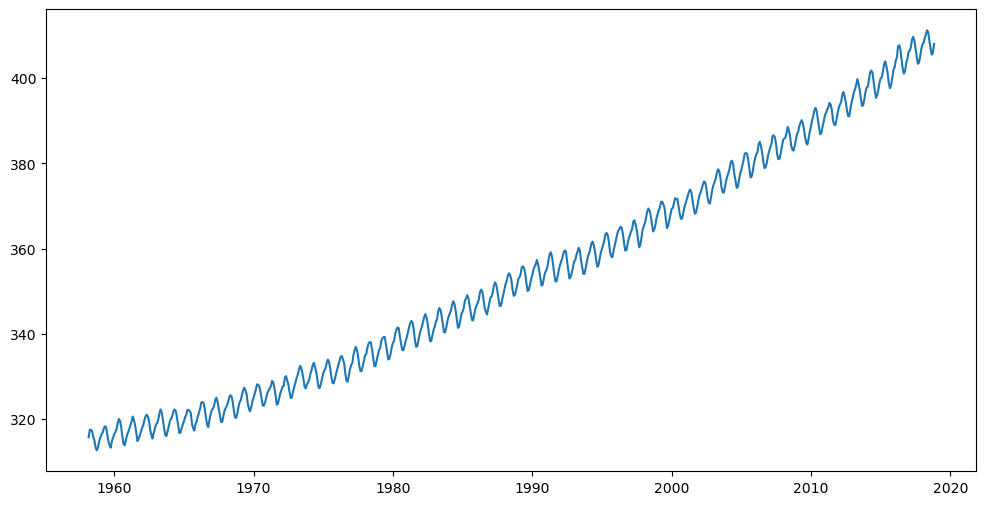

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['interpolated'])

plt.show()

In [11]:
# plot_acf(df['interpolated'], lags=200)
# plt.title('Autocorrelation Function (ACF)')
# plt.show()

In [12]:
# from scipy.signal import periodogram

# # Calculate the periodogram
# frequencies, spectrum = periodogram(df['interpolated'], scaling='spectrum')

# # Plot the periodogram
# plt.figure(figsize=(12, 6))
# plt.plot(frequencies, spectrum)
# plt.title('Periodogram')
# plt.xlabel('Frequency')
# plt.ylabel('Power Spectrum')
# plt.show()


# Fourier Transform

In [13]:
# from numpy.fft import fft

# # Perform Fourier transform
# fft_result = fft(df)

# # Find the frequency with the highest magnitude
# frequencies = np.fft.fftfreq(len(fft_result))
# dominant_frequency = abs(frequencies[np.argmax(np.abs(fft_result))])

# # Calculate the period corresponding to the dominant frequency
# seasonal_period = int(1 / dominant_frequency)

# print(f"Suggested seasonal period: {seasonal_period}")


In [14]:
from pmdarima.arima.utils import nsdiffs

# load lynx
# lynx = load_lynx()

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(df,m=12,
            test='ch')  # -> 0
D

0

In [15]:
SARIMA_model = auto_arima(df['interpolated'], start_p=0, start_q=0,
                         test='adf', 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1783.746, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2369.532, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1614.808, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2375.248, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1935.623, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=431.812, Time=4.43 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=791.747, Time=1.30 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=467.820, Time=8.59 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=437.642, Time=8.02 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1425.289, Time=2.96 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=617.368, Time=4.57 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=14.36 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   :

In [16]:
class TSA_seasonal:
    def __init__(self, df):
        self.df = df

    def adf_test(self, valcol):
        """
        Pass in a time series and an optional title, returns an ADF report
        """
        result = adfuller(self.df[valcol].dropna(), autolag='AIC')  # .dropna() handles differenced data

        labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
        out = pd.Series(result[0:4], index=labels)

        for key, val in result[4].items():
            out[f'critical value ({key})'] = val

        if result[1] <= 0.05:
            state = "Stationary"
        else:
            state = "Non-stationary"
        return state

    def determine_SARIMA_order(self, valcol):
        stepwise_fit = auto_arima(self.df[valcol], seasonal=True, m=12,
#                               start_p=0, start_q=0,
#                               start_P=0, start_Q=0,
                                  error_action='ignore',  # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)  # set to stepwise
        best_order = stepwise_fit.get_params().get('order')
        best_seasonal_order = stepwise_fit.get_params().get('seasonal_order')
        print('The best seasonal order is {}'.format(best_seasonal_order))
        print('The best order is {}'.format(best_order))
        return best_order, best_seasonal_order

    def fit_model(self, valcol):
    # Split the data into train, test, and validation sets
        train = self.df[valcol][:len(self.df[valcol]) - 12]
        test = self.df[valcol][len(self.df[valcol]) - 12:len(self.df[valcol]) - 8]
        val = self.df[valcol][len(self.df[valcol]) - 8:]

        # Determine the best SARIMA order
        best_order, best_seasonal_order = self.determine_SARIMA_order(valcol)

        # Fit the SARIMA model on the training data
        model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
        results = model.fit()

        # Generate predictions for the test set
        predictions = results.predict(start=len(train), end=len(train) + len(test) - 1)

        # Generate predictions for the validation set
        predictions_val = results.predict(start=len(train) + len(test), end=len(train) + len(test) + len(val) - 1)

        # Calculate error metrics for the test set
        error1 = mean_squared_error(test, predictions)
        error2 = mean_squared_error(test, predictions, squared=False)  # RMSE
        error3 = mean_absolute_percentage_error(test, predictions)
        accuracy = (1 - error3) * 100
        print(f'MSE Error: {error1:11.10}')
        print(f'RMSE Error: {error2:11.10}')
        print(f'MAPE Error: {error3:11.10}')
        print(f'Accuracy: {accuracy:11.10}')
        return predictions_val

    def full_data_model(self, valcol):
        best_order, best_seasonal_order = self.determine_SARIMA_order(valcol)
        model = SARIMAX(self.df[valcol], order=best_order, seasonal_order=best_seasonal_order)
        results = model.fit()
        fcast = results.forecast(steps=8).round(2)  # Forecast 4 steps ahead
#         print(fcast)
#         fcast_index = pd.date_range(start=self.df.index[-1], periods=4 + 1, freq='M')[1:]  # Assuming monthly data
        DF_fcast = pd.DataFrame({valcol: fcast})
        DF_fcast['Type'] = 'Predicted'
        print(DF_fcast)
        DF = pd.DataFrame(self.df[valcol])
        DF['Type'] = 'Actual'
        # Concatenate original data and forecast data
        combined_DF = pd.concat([DF, DF_fcast])
        combined_DF = combined_DF.reset_index().rename(columns={'index':'Date'})
        print(combined_DF)
        DF_val = pd.DataFrame(c2.fit_model(valcol))
        DF_val = DF_val.reset_index()
        DF_val = DF_val.rename(columns={'index':'Date','predicted_mean':'Validation'})
#         combined_DF = combined_DF.rename(columns={'index':'Date'})
        print(DF_val)
        print(combined_DF)
#         final_DF =  final_DF.merge(DF_val, on='DateTime',how='outer')
        final_DF =  combined_DF.merge(DF_val, on='Date',how='outer')
        final_DF['Date'] = final_DF['Date'].astype('str')
#         print(combined_df)
        return final_DF
    
    
c2 = TSA_seasonal(df)
c2.adf_test("interpolated")
c2.determine_SARIMA_order("interpolated")
c2.fit_model("interpolated")
c2.full_data_model("interpolated")

The best seasonal order is (1, 0, 1, 12)
The best order is (2, 1, 1)
The best seasonal order is (1, 0, 1, 12)
The best order is (2, 1, 1)


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE Error: 0.03324299893
RMSE Error: 0.182326627
MAPE Error: 0.0004142421844
Accuracy: 99.95857578
The best seasonal order is (1, 0, 1, 12)
The best order is (2, 1, 1)


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            interpolated       Type
2018-12-01        409.26  Predicted
2019-01-01        410.42  Predicted
2019-02-01        411.08  Predicted
2019-03-01        411.99  Predicted
2019-04-01        413.44  Predicted
2019-05-01        414.09  Predicted
2019-06-01        413.36  Predicted
2019-07-01        411.62  Predicted
          Date  interpolated       Type
0   1958-03-01        315.71     Actual
1   1958-04-01        317.45     Actual
2   1958-05-01        317.50     Actual
3   1958-06-01        317.10     Actual
4   1958-07-01        315.86     Actual
..         ...           ...        ...
732 2019-03-01        411.99  Predicted
733 2019-04-01        413.44  Predicted
734 2019-05-01        414.09  Predicted
735 2019-06-01        413.36  Predicted
736 2019-07-01        411.62  Predicted

[737 rows x 3 columns]
The best seasonal order is (1, 0, 1, 12)
The best order is (2, 1, 1)


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE Error: 0.03324299893
RMSE Error: 0.182326627
MAPE Error: 0.0004142421844
Accuracy: 99.95857578
        Date  Validation
0 2018-04-01  411.038493
1 2018-05-01  411.642727
2 2018-06-01  410.863709
3 2018-07-01  409.174230
4 2018-08-01  407.074168
5 2018-09-01  405.624008
6 2018-10-01  405.894226
7 2018-11-01  407.427617
          Date  interpolated       Type
0   1958-03-01        315.71     Actual
1   1958-04-01        317.45     Actual
2   1958-05-01        317.50     Actual
3   1958-06-01        317.10     Actual
4   1958-07-01        315.86     Actual
..         ...           ...        ...
732 2019-03-01        411.99  Predicted
733 2019-04-01        413.44  Predicted
734 2019-05-01        414.09  Predicted
735 2019-06-01        413.36  Predicted
736 2019-07-01        411.62  Predicted

[737 rows x 3 columns]


,Date,interpolated,Type,Validation
0,1958-03-01,315.71,Actual,NaN
1,1958-04-01,317.45,Actual,NaN
2,1958-05-01,317.50,Actual,NaN
3,1958-06-01,317.10,Actual,NaN
4,1958-07-01,315.86,Actual,NaN
...,...,...,...,...
732,2019-03-01,411.99,Predicted,NaN
733,2019-04-01,413.44,Predicted,NaN
734,2019-05-01,414.09,Predicted,NaN
735,2019-06-01,413.36,Predicted,NaN


In [ ]:
predicted=406.5991747, expected=406.81
predicted=407.8151717, expected=407.96
predicted=408.5703387, expected=408.32
predicted=409.4798568, expected=409.41
predicted=411.0384935, expected=410.24
predicted=411.6427265, expected=411.24
predicted=410.8637093, expected=410.79
predicted=409.1742299, expected=408.71
predicted=407.0741681, expected=406.99
predicted=405.624008 , expected=405.51
predicted=405.894226 , expected=406.0
predicted=407.4276173, expected=408.02